In [1]:
import numpy as np
import pandas as pd
import gzip
from sklearn import svm
import cv2
from sklearn.metrics import accuracy_score
from sklearn.utils import  shuffle
import ot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def load_images(file_path):
    with gzip.open(file_path, 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16)
    return images.reshape(-1, 28, 28)/255.0


def load_labels(file_path):
    with gzip.open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels


train_images = load_images('手写数字/train-images-idx3-ubyte.gz')
train_labels = load_labels('手写数字/train-labels-idx1-ubyte.gz')
test_images = load_images('手写数字/t10k-images-idx3-ubyte.gz')
test_labels = load_labels('手写数字/t10k-labels-idx1-ubyte.gz')

#train_images,train_labels=shuffle(train_images,train_labels,random_state=42)
#test_images, test_labels = shuffle(test_images, test_labels, random_state=42)


In [4]:
# 创建空数组用于存放调整后的图像
train_images_resized = np.zeros((train_images.shape[0], 20, 20))

for i in range(train_images.shape[0]):
    # 使用 OpenCV 进行缩放
    train_images_resized[i] = cv2.resize(train_images[i], (20, 20))

# 创建空数组用于存放调整后的图像
test_images_resized = np.zeros((test_images.shape[0], 20, 20))

for i in range(test_images.shape[0]):
    # 使用 OpenCV 进行缩放
    test_images_resized[i] = cv2.resize(test_images[i], (20, 20))

In [58]:
import numpy as np

def create_balanced_dataset(images, labels, samples_per_class=15):
    # 获取所有类别的唯一标签
    unique_labels = np.unique(labels)
    
    # 初始化列表以存储每个类别的样本和标签
    selected_images = []
    selected_labels = []
    
    # 遍历每个类别
    for label in unique_labels:
        # 找到当前类别的所有样本的索引
        indices = np.where(labels == label)[0]
        
        # 随机选择samples_per_class个索引
        selected_indices = np.random.choice(indices, samples_per_class, replace=False)
        
        # 根据选中的索引提取样本和标签
        selected_images.append(images[selected_indices])
        selected_labels.append(labels[selected_indices])
    
    # 将所有类别的样本和标签合并
    return np.vstack(selected_images), np.hstack(selected_labels)

# 创建平衡数据集
balanced_images, balanced_labels = create_balanced_dataset(train_images_resized, train_labels)

# 检查结果
print(f"Balanced dataset shape: {balanced_images.shape}")  # 应为 (3000, 28, 28)
print(f"Balanced labels shape: {balanced_labels.shape}")   # 应为 (3000,)


Balanced dataset shape: (150, 20, 20)
Balanced labels shape: (150,)


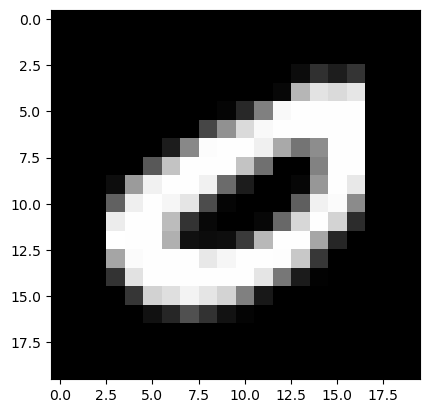

In [51]:
plt.imshow(balanced_images[10],cmap='gray')

In [52]:
balanced_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [59]:
balanced_images,balanced_labels=shuffle(balanced_images, balanced_labels,random_state=42)


In [9]:
# 选择标签为0的图片的索引
zero_label_indices = np.where(balanced_labels == 0)[0]

# 根据索引提取标签为0的图片
zero_images = balanced_images[zero_label_indices]

In [10]:
# 选择标签为1的图片的索引
one_label_indices = np.where(balanced_labels == 1)[0]

# 根据索引提取标签为1的图片
one_images = balanced_images[one_label_indices]

In [11]:
# 选择标签为2的图片的索引
two_label_indices = np.where(balanced_labels == 2)[0]

# 根据索引提取标签为2的图片
two_images = balanced_images[two_label_indices]

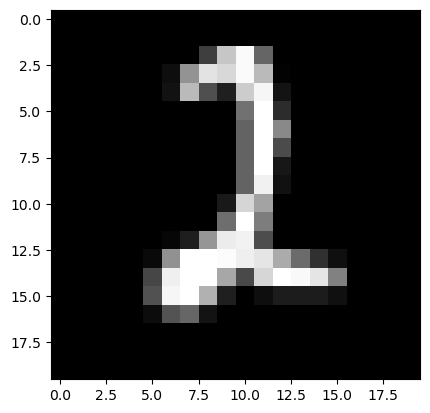

In [12]:
plt.imshow(two_images[1],cmap='gray')

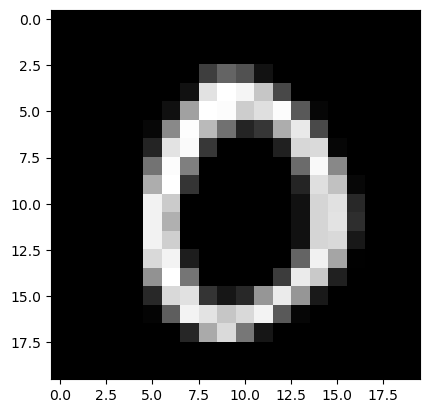

In [13]:
plt.imshow(zero_images[2],cmap='gray')
plt.show()

In [221]:
import ot  # 导入 POT 库

# 2. 选择标签为 0 和 1 的图像，并各取一个样本
X1 = train_images_resized[train_labels == 0][10]  # 取第一个标签为 0 的样本
X2 = train_images_resized[train_labels == 0][10]  # 取第一个标签为 1 的样本

# 3. 计算两个图像之间的代价矩阵
# 假设 X1 和 X2 都是展平后的图像向量 (784,)
# 这里我们使用像素之间的平方欧氏距离作为代价矩阵
X1 = X1.reshape(-1, 1)  # 将图像 X1 展平为 (400, 1)
X2 = X2.reshape(-1, 1)  # 将图像 X2 展平为 (400, 1)
cost_matrix = ot.dist(X1, X2, metric='euclidean')  # 计算平方欧氏距离作为代价矩阵

# 定义两个图像的权重分布（均匀分布）
r = (X1+0.000000001)/np.sum(X1) # 源分布权重 (400,)
c = (X2+0.000000001)/np.sum(X2)  # 目标分布权重 (400,)

# 5. 计算 Sinkhorn 距离
# 使用 ot.sinkhorn2 方法计算带有正则化的 Sinkhorn 距离
sinkhorn_distance = ot.sinkhorn2(r, c, cost_matrix, reg=1e-3)


print(f"Sinkhorn Distance: {sinkhorn_distance}")


Sinkhorn Distance: [0.0001913]


In [222]:
def sinkhorn_kernel(X,Y,gamma=10):
    n=X.shape[0]
    m = Y.shape[0]
    #初始化核矩阵
    kernel_matrix = np.zeros((n,m))
    # 逐对样本计算 Sinkhorn 距离，并转化为相似度
    for i in range(n):
        for j in range(m):
            M=ot.dist(X[i], Y[j], metric='euclidean')
            r = np.ones(X[i].shape[0]) / X[i].shape[0]  # 源分布权重 (400,)
            c = np.ones(Y[j].shape[0]) / Y[j].shape[0]  # 目标分布权重 (400,)
            sinkhorn_distance = ot.sinkhorn2(r, c, M, reg=9,stopThr=1e-9)
            #论文里k=exp(-reg*M)
            #库函数是 K = nx.exp(M / (-reg))
            # 使用 RBF 核公式将距离转化为相似度
            kernel_matrix[i, j] = np.exp(-gamma * sinkhorn_distance)
            #内核exp(-d/t)
    
    return kernel_matrix
    

In [61]:
x_train,x_test,y_train,y_test=train_test_split(balanced_images,balanced_labels,random_state=42)

In [193]:
x_train.shape

(112, 20, 20)

In [223]:
train_kernel_matrix = sinkhorn_kernel(x_train, x_train)
test_kernel_matrix = sinkhorn_kernel(x_test, x_train)  # 注意这里是测试集和训练集计算

# 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, y_train)

# 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

# 评估模型性能
accuracy = accuracy_score(y_test, test_preds)
print(f"SVM + Sinkhorn Kernel Accuracy: {accuracy:.4f}")


SVM + Sinkhorn Kernel Accuracy: 0.1316


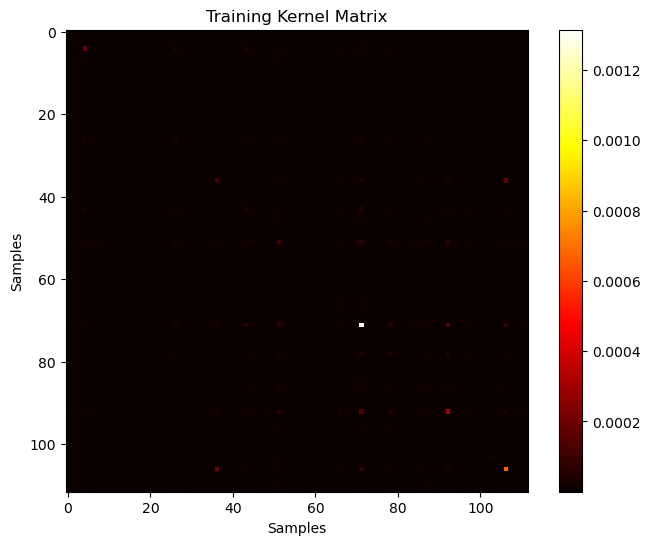

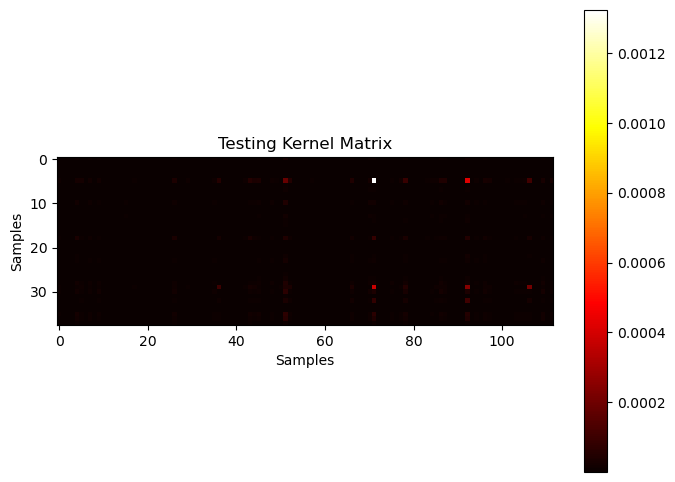

In [212]:
import matplotlib.pyplot as plt

def plot_kernel_matrix(matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Samples')
    plt.show()

# 可视化训练集的 Sinkhorn 核矩阵
plot_kernel_matrix(train_kernel_matrix, 'Training Kernel Matrix')

# 可视化测试集的 Sinkhorn 核矩阵
plot_kernel_matrix(test_kernel_matrix, 'Testing Kernel Matrix')


In [ ]:
def squared_euclidean_kernel(X, Y, gamma=0.1):
    n = X.shape[0]
    m = Y.shape[0]
    # 初始化核矩阵
    kernel_matrix = np.zeros((n, m))
    
    # 逐对样本计算平方欧几里得距离，并转化为相似度
    for i in range(n):
        for j in range(m):
            # 计算平方欧几里得距离
            squared_distance = np.sum((X[i] - Y[j]) ** 2)
            # 使用 RBF 核公式将距离转化为相似度
            kernel_matrix[i, j] = np.exp(-gamma * squared_distance)
    
    return kernel_matrix

In [86]:
# 计算训练集和测试集的 g 核矩阵 1000个样本 stopThr=1e-9

train_kernel_matrix = squared_euclidean_kernel(x_train, x_train)
test_kernel_matrix = squared_euclidean_kernel(x_test, x_train)  # 注意这里是测试集和训练集计算

# 4. 使用 SVM 进行训练，注意 kernel='precomputed' 表示自定义核
clf = svm.SVC(kernel='precomputed')
clf.fit(train_kernel_matrix, y_train)

# 5. 使用训练好的模型进行预测
test_preds = clf.predict(test_kernel_matrix)

# 6. 评估模型性能
accuracy = accuracy_score(y_test, test_preds)
print(f"SVM + squared Kernel Accuracy: {accuracy:.4f}")


SVM + squared Kernel Accuracy: 0.7105


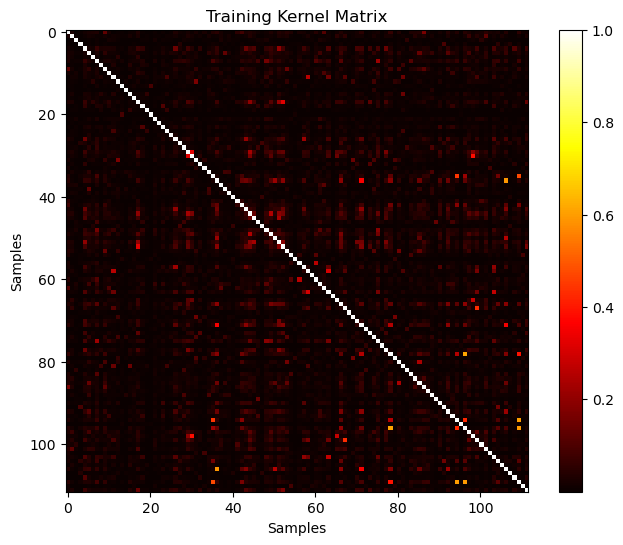

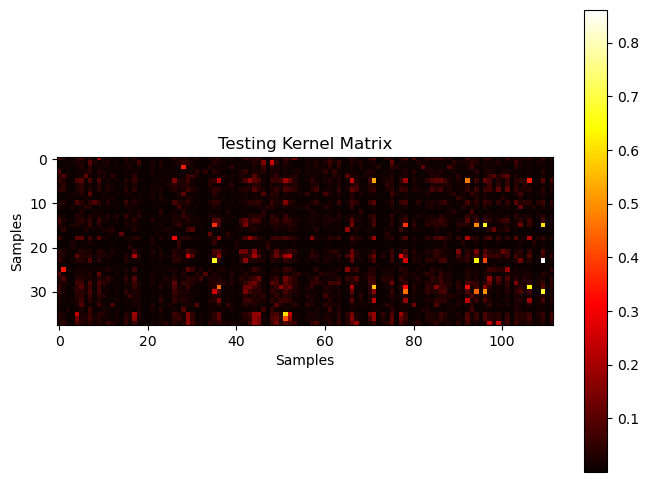

In [74]:
import matplotlib.pyplot as plt

def plot_kernel_matrix(matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Samples')
    plt.show()

# 可视化训练集的 Sinkhorn 核矩阵
plot_kernel_matrix(train_kernel_matrix, 'Training Kernel Matrix')

# 可视化测试集的 Sinkhorn 核矩阵
plot_kernel_matrix(test_kernel_matrix, 'Testing Kernel Matrix')
